# Introduction

We often train machine learning models to assign samples to a class. Take for instance the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, where images of handwritten digits between 0 and 9 have to be assigned to *one* of 10 possible classes. Another example, and this is the dataset we'll consider in this post, is the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/), which contains more than 7000 images of cats and dogs from 37 different breeds. Our goal is to assign the right breed to each image.
The scenario just described is typically approached as a [multi-class classification](https://en.wikipedia.org/wiki/Multiclass_classification) problem, in which samples have to be assigned to *one* of $N$ possible classes.

Let's say we have already trained our pet breed classifier and want to roll it out so that other people can interact with it. In such an environment no one can prevent a user from loading an image that does not belong to *any* of the classes known to our model. And even if someone were to do so, our model would still return one of the 37 breeds&mdash;it has no ability to say "it's none of the breeds I know". Our goal is to create a model that can do just that!

Although this seems to be a fairly common problem, I have seen many people struggling to find a solution. One might be tempted to add an additional class (let's call it *is_other*) to which all samples that do not contain any instance of a known class will be assigned. However, as Jeremy Howard explains in one of the lectures of his course [Deep Learning from the Foundations](https://course19.fast.ai/part2), this is not a great idea. The main reason is that our model would have to learn the features that distinguish the negative of every other class we are interested in. An approach that might work better instead is to treat our problem as if it were a multi-label classification task.

:::{.callout-note}

You can reproduce all the results presented below by accessing the notebook used to create this post. If you do so, make sure you have access to a GPU. This speeds up the execution time considerably!

:::

In [9]:
#| include: false
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install fastai==2.5.3 -q
    !pip install nbdev -q

In [1]:
#| include: false
from fastai.vision.all import *

# Multi-class classification

The dataset can easily be downloaded using the fastai's `untar_data` function, which downloads and extracts it for us (if not already available). This function returns a `pathlib.Path` object.

In [2]:
#| output: false
path = untar_data(URLs.PETS)

In [3]:
#| include: false
# Display paths relative to `path`
Path.BASE_PATH = path

All images are stored in the *images* subdirectory. To collect all filenames, we can use the fastai's `get_image_files` function. This function recursively gets all the image files in the given path and returns an [`L` object](https://fastcore.fast.ai/foundation.html#L), which is a sort of Python list on steroids.

In [4]:
# Get image files in `path/images`
fns = get_image_files(path/"images")
fns[:3]

(#3) [Path('images/Egyptian_Mau_167.jpg'),Path('images/pug_52.jpg'),Path('images/basset_hound_112.jpg')]

We can see that the pet breed is part of the filename. Next, we'll use **regular expressions** to extract it so that it can then be used as target label for our model.

## Constructing a DataBlock and DataLoaders

Those already familiar with PyTorch know that there are two main classes for accessing a dataset: the `Dataset` and `DataLoader`. On top of that, fastai offers two classes, the `Datasets` and `DataLoaders`, for bringing traning and validation `Dataset`s and `DataLoader`s together. 

We'll now create a `DataBlock`, which is sort of template for creating a DataLoaders later on. Here is the code, with an explanation of each line immediately afterwards.

In [6]:
name_regex = r"(.+)_\d+\.jpg$"

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(name_regex), attr='name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

First, we need to specify what data we are working with. Our *independent* variables are images (hence `ImageBlock`), while our *dependent* variables are labels (hence `CategoryBlock`, which returns a single integer). Second, we need to tell fastai how to get the list of items in our dataset. As we saw before, the function `get_image_files` does exactly that. We then decide to split our data randomly, which is what the `RandomSplitter` does. By default, it keeps 80% of the data for training and puts the remaining 20% in the validation set. The DataBlock now knows how go get and split data, but it doesn't know how to label these items. We specify this with the `get_y` argument. A handy class to label samples with regular expressions is `RegexLabeller`. Note that we cannot pass items directly to it as they are&mdash;the elements in `fns` are pathlib.Path objects, not strings (see above)&mdash;but we have to use the `.name` attribute. This is what `using_attr` does. Lastly, we resize every image to the same size (460 x 460 pixels) so that we can apply data augmentation to batches on the GPU. 

We can now build our DataLoaders! But before moving on, we want to make sure that things have gone as planned. To do so, we'll check out a few samples.

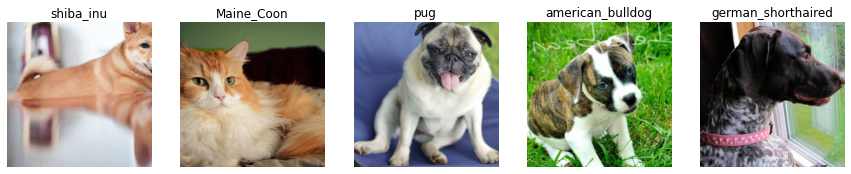

In [8]:
# Create DataLoaders
dls = dblock.dataloaders(path/"images")
dls.show_batch(nrows=1, ncols=5)

## Model training

Once we are convinced that our data have been prepared correctly, we can proceed with the creation of a deep learning model. We're going to keep things simple here as we want the training to be short. For this reason, we'll proceed with a **ResNet18** model, which is a pretty small Convolutional Neural Network (CNN) by today's standards.

The *learning rate* is one of the hyperparameters that has the greatest influence on the training of neural networks. Practitioners usually set it to a value they like or tune it via hyperparameter sweeps. fastai provides us with the `lr_find` method, which implements a version of the **learning rate finder** originally proposed by Leslie Smith.

SuggestedLRs(valley=0.0014125375309959054)

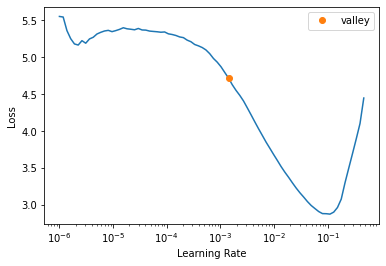

In [ ]:
# Create CNN model (ResNet18)
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn.lr_find(start_lr=1e-6)

We opt for an aggressive value for the learning rate, which allows us to train the model for a small number of epochs. We'll train the model's head for 1 epoch, while keeping the rest of the weights frozen; then we unfreeze all the weights and continue the training for 4 more epochs. 

All this is packaged in the `fine_tune` method.

In [ ]:
# Fine-tune model
learn.fine_tune(4, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.403973,0.382155,0.121110,0.878890,01:25


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.518523,0.352880,0.117050,0.882950,01:29
1,0.456349,0.321530,0.097429,0.902571,01:34
2,0.308262,0.233842,0.072395,0.927605,01:29
3,0.176608,0.223449,0.065629,0.934371,01:29


We can already see from this table that the training was quite successful&mdash;the error rate is less than 7%. We can now take a look at some predictions on the validation set, which can be obtained through the method `show_results`. 

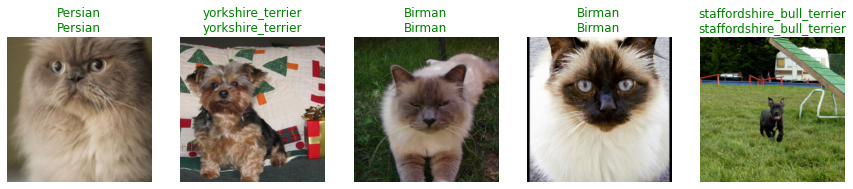

In [ ]:
# Display couple of results
learn.show_results(max_n=5, nrows=1)

In [ ]:
#| include: false
# Store model to disk
learn.export('multi-class.pkl')

Now that we are confident enough that our model is working well, we can put it to the test by passing it some pictures found on the web. Let's start with the image of a [cat](https://www.zooplus.it/magazine/wp-content/uploads/2018/05/AdobeStock_219606483-768x512-1.jpeg) whose breed is known to our model and see how it behaves.

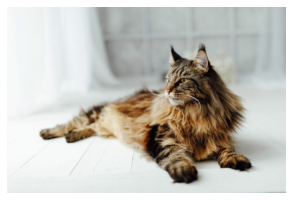

In [37]:
img_cat = PILImage.create('maine_coon.jpeg')
img_cat.show();

In [ ]:
learn.predict(img_cat)[0]

'Maine_Coon'

The model correctly predicts that it is a maine coon cat&mdash;so far so good! Let's try now with a picture of something it has never seen before, for example an [elephant](https://media.istockphoto.com/photos/background-elephant-picture-id479667835?k=20&m=479667835&s=612x612&w=0&h=Zy5JdCC9SqOL2Tf5SHSM0VdjaKdn2xt_jZi8SOy-USY=)?

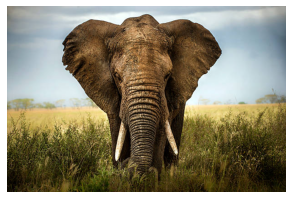

In [39]:
img_el = PILImage.create('elephant.jpg')
img_el.show();

In [ ]:
learn.predict(img_el)[0]

'British_Shorthair'

Here the model tells us that it is a british shorthair cat. Instead, we would like the model to tell us when it doesn't know something. However, the current model has no way of doing this because it was built that way.
Note that when we've instantiated our `Learner` above, we didn't specify what loss function to use. This is because fastai is smart enough to select the right one for us, which in this case is the **cross-entropy** loss. Also, to turn the activations into actual predictions, the last layer uses the **softmax** activation function. By construction, the softmax really wants to pick *one* class among the available&mdash;after all, the outputs of a softmax layer have to add up to 1 and the largest activation value is magnified even more. In the next section, we will see how by reformulating the problem we can achieve the desired behavior.

:::{.callout-tip}

If you have not set the loss function yourself and you are unsure of what fastai has chosen for you, you can always inspect the `.loss_func` attribute of your `Learner`.

:::

# Multi-label classification

We'll now go back to the beginning and reformulate the pet breeds classification problem as a multi-label classification task. In this way, we should be able to tell if an image does *not* belong to any of the breeds seen during training.

## Constructing a DataBlock and DataLoaders

In the multi-class case, we used the `CategoryBlock`, while here we'll switch to the `MultiCategoryBlock`, which returns a *one-hot encoded* vector. This block expects a *list* of labels (strings), hence we need to modify a bit the `get_y` function, which was only returning the pet breed as a string. The next cell defines this function, builds new DataBlock and DataLoaders, and displays a few samples.

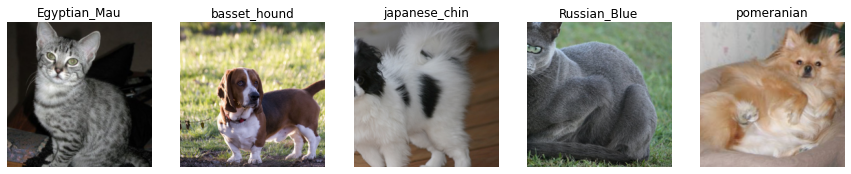

In [11]:
def get_y(fp):
    """Get list of labels from df."""
    lbl = using_attr(RegexLabeller(name_regex), attr="name")(fp)
    return [lbl]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=get_y,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls = dblock.dataloaders(path/"images")
dls.show_batch(nrows=1, ncols=5)

## Model training

Before creating a new model and launching the learning rate finder, we'd like to point out some differences in relation to what we have done above. First, even if we don't do so explicitly, fastai will again choose the correct loss function for us, which in this case is the **binary cross-entropy** loss.
The activation function of the final layer is no longer the softmax, rather the **sigmoid** function. The outputs of this layer therefore no longer have to add up to one, but each neuron can return a value between 0 and 1 regardless of the others. This means that we also need to adapt our metric. In the multi-class case, the accuracy was comparing the target label with the class with highest activation (via `argmax`). But now these activations might even be all 1 in theory, or all 0. We hence need to pick a threshold to decide what has to be set to 0 and what to 1. This is what `accuracy_multi` does.

SuggestedLRs(valley=0.003162277629598975)

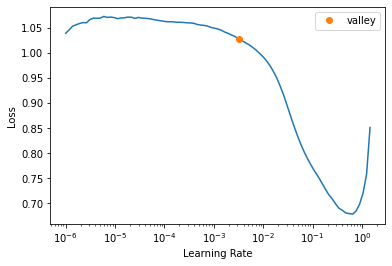

In [29]:
# Create CNN model (ResNet18)
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.7))
learn.lr_find(start_lr=1e-6)

We choose again a learning rate value large enough to have a reasonably fast training and launch it.

In [30]:
# Fine-tune model
learn.fine_tune(4, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.319909,0.029859,0.981696,01:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.034611,0.028626,0.986578,01:33
1,0.030179,0.023405,0.988754,01:33
2,0.018344,0.015487,0.992576,01:32
3,0.010457,0.013025,0.993472,01:32


The results seem promising, so we move on and display a few predictions on the validation set.

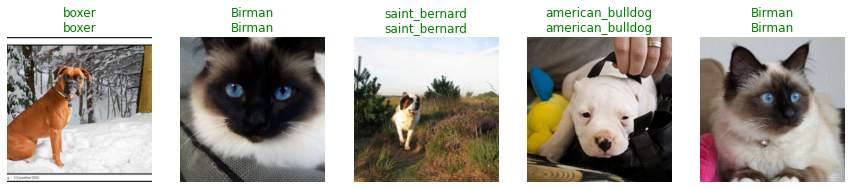

In [32]:
# Display couple of results
learn.show_results(max_n=5, nrows=1)

In [33]:
#| include: false
# Store model to disk
learn.export('multi-label.pkl')

The crucial moment is approaching: we want to see how the model behaves when we show it new pictures and, in particular, pictures depicting things it doesn't know. We hence repeat the previous experiment by passing it the image of a cat.

In [38]:
# Increase threshold, i.e. assign a label only when very confident.
learn.loss_func = BCEWithLogitsLossFlat(thresh=0.7)

learn.predict(img_cat)[0]

(#1) ['Maine_Coon']

All good for now, it correctly predicts that it's a maine coon. But what about the image of the elephant? 

In [40]:
learn.predict(img_el)[0]

(#0) []

Great! Our model doesn't recognise the content of this picture and hence doesn't return any label! 🎉

# Acknowledgements and references

This post is inspired by the fantastic course [Practical Deep Learning for Coders](https://course.fast.ai/) taught at fast.ai and the material kindly provided by Zachary Mueller through the [Walk with fastai](https://walkwithfastai.com/) project.